In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
import math

## Data Structuring

In [2]:
df_juan = pd.read_csv("..//resources//csv//data//biometrics-juan.csv")
df_rocio = pd.read_csv("..//resources//csv//data//biometrics-rocio.csv")
df_matias = pd.read_csv("..//resources//csv//data//biometrics-matias.csv")
df_bren = pd.read_csv("..//resources//csv//data//biometrics-bren.csv")

In [3]:
dfs = [df_rocio, df_juan, df_matias, df_bren]

In [4]:
def standarize(df):
    df_to_standarize = df.copy()
    
    # remover las mediciones sin estímulo antes de la estandarización, para no afectar la desviación
    filterArousal = df_to_standarize['ArousalMean'] > 0
    filtered1 = df_to_standarize[filterArousal]

    # remover las mediciones para las que el sam no coincidió antes de la estandarización, para no afectar la desviación
    # filterSam = filtered1['MatchesSam'] == True
    # filtered = filtered1[filterSam]
    
    columns_to_standarize = ['HR', 'HRV', 'MicroSiemens']

    scaler = preprocessing.StandardScaler()
    standarized_df = scaler.fit_transform(df_to_standarize[columns_to_standarize])

    standarized_df_with_arousal = np.append(standarized_df, df_to_standarize[['ArousalMean']], axis=1)

    # Convert it to dataframe
    standarized_df_with_arousal = pd.DataFrame(standarized_df_with_arousal, columns=['HR', 'HRV', 'MicroSiemens', 'ArousalMean'])

    return standarized_df_with_arousal

In [5]:
# Se estandariza cada dataframe
standarized_dfs = list(map(standarize, dfs))

# Se los une a todos en un solo dataframe para entrenamiento luego de la estandarización
biometrics_df = pd.concat(standarized_dfs)

# sns.pairplot(biometrics_df, height=3.5);
# plt.show()

## Correlation Analysis

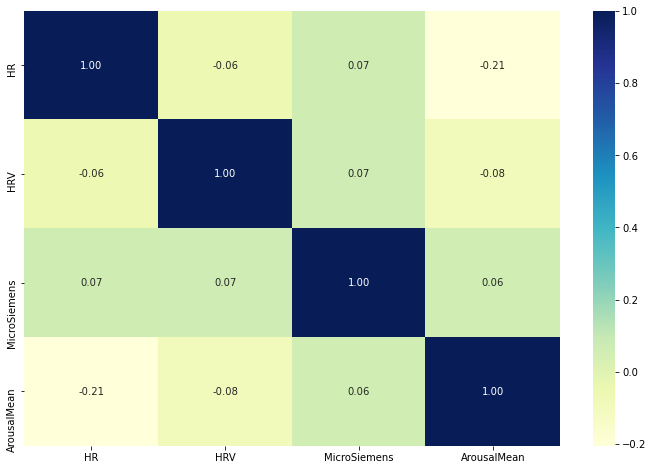

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(biometrics_df.corr(), annot=True, fmt=".2f", cmap='YlGnBu')
plt.show()

In [7]:
X = biometrics_df[['MicroSiemens', 'HR', 'HRV' ]].values
y = biometrics_df['ArousalMean'].values

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [10]:
# Para poder usar un clasificador, los datos de la variable target deben ser discretos.
#Los convertimos a True-False (Aroused-NotAroused) con el fin de poder entrear un clasificador binario
y_train_aroused = (y_train > 5)
y_test_aroused = (y_test > 5)

In [11]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train_aroused)

SVC()

# Prediction

In [12]:
clf.predict(X[145].reshape(1, -1))

array([False])

# Performance Measuring

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
cross_val_score(clf, X_train, y_train_aroused, cv=3, scoring='accuracy')

array([0.63141026, 0.34935897, 0.5755627 ])

# Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict

In [16]:
# y_train_pred = cross_val_predict(clf, X_train, y_train_aroused, cv=3)
y_test_pred = clf.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
confusion_matrix(y_test_aroused, y_test_pred)

array([[ 64,  61],
       [109,   0]])

In [19]:
pd.DataFrame(confusion_matrix(y_test_aroused, y_test_pred),
             columns=pd.MultiIndex.from_product([['Prediction'], ["Negative", "Positive"]]),
             index=pd.MultiIndex.from_product([["Actual"], ["Negative", "Positive"]]))

Prediction         
                  Negative Positive
Actual Negative         64       61
       Positive        109        0

In [20]:
from sklearn.metrics import precision_score, recall_score

In [21]:
precision_score(y_test_aroused, y_test_pred)

0.0